<a href="https://colab.research.google.com/github/MoAbboud/Pneumonia/blob/main/Carlos_draft_PythonProjectResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers, optimizers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.resnet import ResNet50 #loading the resnet50 model
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#read the image
# function to load the dataset and return the dataset list
# containing elements of format [scans, target]
targets = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(scans):
    data = list()
    for target in targets: 
        path = os.path.join(scans, target)
        class_label = targets.index(target)
        for img in os.listdir(path):
            try:
                arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(arr, (img_size, img_size))
                data.append([resized_arr, class_label])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#extracting the dataset
train = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/test')
val = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/val')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#split the data into training, testing and validation groups with variables to hold the target names.
images = []
labels = []

for image_scan, target in train:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in test:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in val:
    images.append(image_scan)
    labels.append(target)

In [ ]:
# Normalize data
images = np.array(images) / 255

In [ ]:
# resize data
images = images.reshape(-1, img_size, img_size, 3)
labels = np.array(labels)

In [ ]:
#prevents overfitting and handles the imbalance in dataset

data_aug = ImageDataGenerator(
        rotation_range = 30,  #rotate 
        zoom_range = 0.2, #  zoom  
        width_shift_range=0.1,  #  shift images horizontally 
        height_shift_range=0.1,  #  shift images vertically
        horizontal_flip = True,  # flip images
        vertical_flip=False)  # no vertical flip

data_aug.fit(images)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.30, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.30, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4099, 150, 150, 3)
(1229, 150, 150, 3)
(528, 150, 150, 3)


In [ ]:
X_train.shape[1:]

(150, 150, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

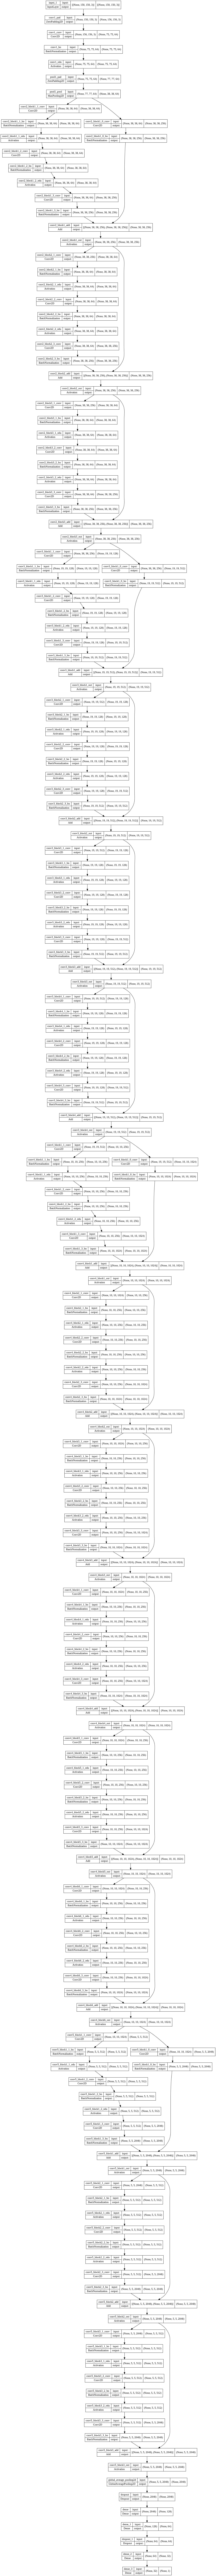

In [ ]:
#building the model

resNet  = ResNet50( input_shape=X_train.shape[1:], include_top=False)

# freezing restNet layers
for layer in resNet.layers:
  layer.trainable = False

l = resNet.output
# adding Maxpool layer
l = GlobalAveragePooling2D()(l)
l = Dropout(.3)(l)
# adding dense layers
l = Dense(128, activation = 'relu')(l)
l = Dense(64, activation='relu')(l)
l = Dropout(.3)(l)
l = Dense(32, activation='relu')(l)

output_layer =layers.Dense(1, activation='sigmoid')(l)

# creating early stopping.
es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
# creating model checkpoint
mc = ModelCheckpoint("ResNetModel.h5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# creating class weights
#cw = {0: 1.0, 1: 1.0}

resnet_model = Model(inputs=resNet.input, outputs=output_layer)

resnet_model.summary()

plot_model(resnet_model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# compile model
resnet_model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# fitting the model
history = resnet_model.fit(data_aug.flow(X_train, y_train), batch_size = 128, epochs=12, validation_data=(X_test, y_test), callbacks = [es,mc],verbose=1)#,class_weight=cw)#steps_per_epoch= len(y_train),validation_steps= len(y_test))

Epoch 1/12
129/129 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6260
Epoch 1: val_loss improved from inf to 0.57556, saving model to ResNetModel.h5
129/129 [==============================] - 53s 313ms/step - loss: 0.6567 - accuracy: 0.6260 - val_loss: 0.5756 - val_accuracy: 0.7469
Epoch 2/12
129/129 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.7141
Epoch 2: val_loss improved from 0.57556 to 0.57243, saving model to ResNetModel.h5
129/129 [==============================] - 32s 249ms/step - loss: 0.6117 - accuracy: 0.7141 - val_loss: 0.5724 - val_accuracy: 0.7469
Epoch 3/12
129/129 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.7187
Epoch 3: val_loss did not improve from 0.57243
129/129 [==============================] - 32s 244ms/step - loss: 0.6132 - accuracy: 0.7187 - val_loss: 0.5747 - val_accuracy: 0.7469
Epoch 4/12
129/129 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7207
Epoch

In [ ]:
resnet_model.save('PNmodelResNet50.h5')

In [ ]:
resnet_model.evaluate(X_val, y_val)

17/17 [==============================] - 3s 164ms/step - loss: 0.5714 - accuracy: 0.7481
[0.5714200139045715, 0.748106062412262]


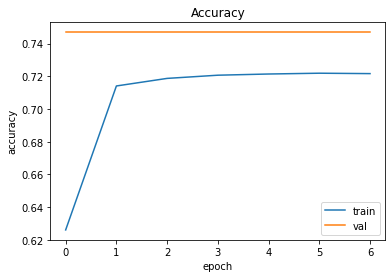

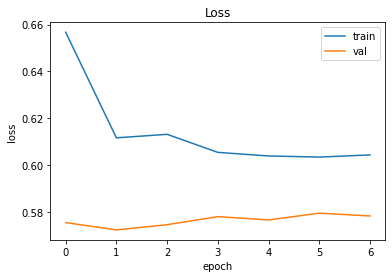

In [ ]:
#plotting the data to demonstrate the accuracy of the train and validations. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

#plotting the data to demonstrate the loss of the train and validations. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
predictions = (resnet_model.predict(X_test) > 0.56).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)